In [99]:
import io
import requests
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import pyspark.sql.functions as F

from copy import deepcopy

from fink_utils.spark.utils import concat_col
from fink_science.ztf.ad_features.processor import extract_features_ad, create_extractor
from fink_utils.photometry.conversion import apparent_flux, mag2fluxcal_snana
from fink_utils.photometry.utils import is_source_behind
from fink_utils.photometry.vect_conversion import vect_dc_mag

Get data of suspicious values

In [2]:
# get data for problematic alert
epochs = {
    'epoch1': [
        '../julien.peloton/archive/science/year=2025/month=08/day=13/']
}


In [3]:
# Read data
to_load = epochs['epoch1'][0]

df1 = spark.read.format('parquet').option('basePath', 
                                  '../julien.peloton/archive/science').load(to_load)

25/08/14 18:52:38 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [4]:
# problematic alert
alert_data = pd.read_csv('data/ZTF19aaochsr.csv')

In [5]:
# get data
df = df1.filter(F.col('objectId') == 'ZTF19aaochsr')

In [6]:
# concatenate current and historical measurements
what = ['magpsf', 'jd', 'sigmapsf', 'fid', 'distnr', 'magnr', 'sigmagnr', 'isdiffpos']

prefix = 'c'

what_prefix = [prefix + i for i in what]

for colname in what:
    df = concat_col(df, colname, prefix=prefix)

Do feature extraction by hand

following what is in the [processor](https://github.com/astrolabsoftware/fink-science/blob/master/fink_science/ztf/ad_features/processor.py)

In [7]:
# create necessary variables
cfid = df.select('cfid').toPandas().values[0][0]
magpsf = df.select('cmagpsf').toPandas().values[0][0]
jd = df.select('cjd').toPandas().values[0][0]
sigmapsf = df.select('csigmapsf').toPandas().values[0][0]
distnr = df.select('cdistnr').toPandas().values[0][0]
sigmagnr = df.select('csigmagnr').toPandas().values[0][0]
isdiffpos = df.select('cisdiffpos').toPandas().values[0][0]
magnr =df.select('cmagnr').toPandas().values[0][0]

In [8]:
# check range of JD  -- if this is only one alert it should be < 30
max(jd) - min(jd)

29.995671299751848

In [9]:
# use it exactly as in the processor
cfid = np.asarray(cfid, "int32")
magpsf = np.asarray(magpsf, "float64")
jd = np.asarray(jd, "float64")
sigmapsf = np.asarray(sigmapsf, "float64")
distnr = np.asarray(distnr, "float64")
sigmagnr = np.asarray(sigmagnr, 'float64')
isdiffpos = np.asarray(isdiffpos, 'bool')
magnr = np.asarray(magnr, 'float64')

In [10]:
# create extractor object from light_curve package
extractor = create_extractor()

In [11]:
# keep only g and/or r -- at some point ZTF decided to sent i-band, we ignore it
passbands = np.unique(cfid)

maskFilter = passbands <= 2
passbands = passbands[maskFilter]    ## this is an array = [1,2]

In [12]:
# Select only valid measurements (not upper limits)
maskNotNone = magpsf == magpsf          # this is not doing anything
mask = ~(np.isnan(magpsf) | np.isnan(sigmapsf)) & maskNotNone

In [13]:
magpsf_real = magpsf[mask]
sigmapsf_real = sigmapsf[mask]
magnr_real = magnr[mask]
sigmagnr_real = sigmagnr[mask]
isdiffpos_real = isdiffpos[mask]

# in the processor this is given the same name, let's keep it here
magpsf = magpsf[mask]
sigmapsf = sigmapsf[mask]

In [14]:
# size of final array
magpsf.shape

(106,)

In [15]:
#number of points per filter
fil, freq = np.unique(cfid[mask], return_counts=True)

In [16]:
print(fil, freq)

[1 2] [97  9]


In [17]:
# check SNR - using apparent flux
flux = []
fluxerr = []

for i in range(len(magpsf_real)):
    f, ferr = apparent_flux(magpsf_real[i], sigmapsf_real[i], magnr_real[i], 
                            sigmagnr_real[i], isdiffpos_real[i])
    flux.append(f)
    fluxerr.append(ferr)
    
app_flux = np.asarray(flux, 'float64')
app_fluxerr = np.asarray(fluxerr, 'float64')

snr_ap_flux = app_flux/app_fluxerr

sum(snr_ap_flux < 5)

0

In [18]:
# check SNR - using magtofluxcal_snana
flux, fluxerr = mag2fluxcal_snana(magpsf_real, sigmapsf_real)
snr_snana = flux/fluxerr
sum(snr_snana < 5)

0

In [19]:
# Compute DC mag if need be -- I am not sure I understand why this is needed
flag = is_source_behind(distnr[mask])
maskDC = np.ones(len(magpsf), dtype=bool)

if np.sum(flag) > 0:
    print('Inside!')
    magnr = np.asarray(magnr, "float64")[mask]
    sigmagnr = np.asarray(sigmagnr, "float64")[mask]
    isdiffpos = np.asarray(isdiffpos, "str")[mask]

    # in-place replacement
    magpsf, sigmapsf = vect_dc_mag(magpsf, sigmapsf, magnr, sigmagnr, isdiffpos)
    maskDC = ~(np.isnan(magpsf) | np.isnan(sigmapsf))
    magpsf = magpsf[maskDC]
    sigmapsf = sigmapsf[maskDC]

Inside!


In [20]:
maskDC.shape

(106,)

In [21]:
# apply both masks -- for some reason
jd = jd[mask][maskDC]
cfid = cfid[mask][maskDC]

In [22]:
# get only useful columns
sub = pd.DataFrame({"magpsf": magpsf, "sigmapsf": sigmapsf, "jd": jd, "cfid": cfid})

In [23]:
# order in jd
sub = sub.sort_values("jd", ascending=True)

In [25]:
# create feature columns names
FEATURES_COLS = create_extractor().names
columns_count = len(FEATURES_COLS)

In [26]:
# check just r-band results before fixing the duplicated issue
full_result = {}

for passband_id in passbands[1:]: # for each passband
    
    passband = sub["cfid"].to_numpy() == passband_id # mask only 1 filter
    
    result = extractor(
                sub["jd"].to_numpy()[passband],
                sub["magpsf"].to_numpy()[passband],
                sub["sigmapsf"].to_numpy()[passband],
                fill_value=np.nan,
        )
    

In [27]:
full_result[int(passband_id)] = dict(
            zip(FEATURES_COLS, [float(v) for v in result])
        )

In [47]:
alert = alert_data[df.select('candid').collect()[0].candid == alert_data['i:candid'].values]

In [65]:
# compare calculated values from those in the broker
l1 = alert['d:lc_features_r'].values[0].split(',')
l2 = [l1[0][1:]] + l1[1:-1] + [l1[-1][:-1]]
l3 = np.array([float(item) for item in l2])

In [96]:
len(l3)

26

In [93]:
l4 = list(full_result[2].values())

In [95]:
len(l4)

26

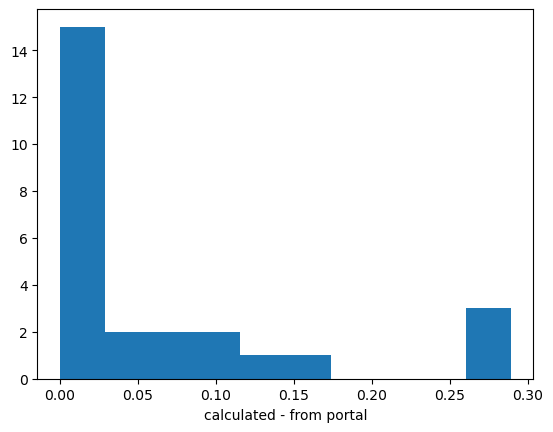

In [100]:
diff = [abs(l4[i] - l3[i]) for i in range(len(l4))]

plt.hist(diff)
plt.xlabel('calculated - from portal')
plt.show()

In [101]:
## this is missing  --- remove duplicates
sub2 = sub.drop_duplicates(subset=['jd'], keep='first') 

In [119]:
# check just r-band results before fixing the duplicated issue
full_result2 = {}

for passband_id in passbands: # for each passband
    
    passband = sub2["cfid"].to_numpy() == passband_id # mask only 1 filter
    
    try:
        result = extractor(
                sub2["jd"].to_numpy()[passband],
                sub2["magpsf"].to_numpy()[passband],
                sub2["sigmapsf"].to_numpy()[passband],
                #fill_value=np.nan,
            )
    except ValueError as err:
        # log if known error, then skip
        if err.args[0] == "t must be in ascending order":
            print(
                    f"Unordered jd for {oId} in processor '{__file__}/{extract_features_ad.__name__}'"
            )
        else:
            print(
                f"Unknown exception for {oId} in processor '{__file__}/{extract_features_ad.__name__}'"
            )
        continue
    except Exception:
        print(
            f"Unknown exception for {oId} in processor '{__file__}/{extract_features_ad.__name__}'"
        )
        continue
       
    full_result2[int(passband_id)] = dict(
            zip(FEATURES_COLS, [float(v) for v in result])
        )
    

In [120]:
full_result2

{1: {'mean': 14.35880071550731,
  'weighted_mean': 14.349268148426722,
  'standard_deviation': 0.04678840881811856,
  'median': 14.354184780262417,
  'amplitude': 0.07540063071876713,
  'beyond_1_std': 0.45,
  'cusum': 0.09310089391851831,
  'inter_percentile_range_10': 0.11530453173099353,
  'kurtosis': -1.57300287990567,
  'linear_trend': 0.00012124160719001416,
  'linear_trend_sigma': 0.0005991957241030409,
  'linear_trend_noise': 0.04717338674637168,
  'linear_fit_slope': 0.0001740028212633198,
  'linear_fit_slope_sigma': 0.00020630963713685915,
  'linear_fit_reduced_chi2': 9.962082406696375,
  'magnitude_percentage_ratio_40_5': 0.4520395058070004,
  'magnitude_percentage_ratio_20_10': 0.8450731265486418,
  'maximum_slope': 292.4942689584346,
  'median_absolute_deviation': 0.04402714340186886,
  'median_buffer_range_percentage_10': 0.05,
  'percent_amplitude': 0.08294225657360244,
  'mean_variance': 0.0032585178766070424,
  'anderson_darling_normal': 2.399765263066554,
  'chi2': 9.